In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

from IPython.display import display
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import shap
from lightgbm import LGBMRegressor

In [2]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')

X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test_random.csv')

In [3]:
X_train.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [4]:
data = pd.concat([X_train, X_test]).reset_index(drop=True).sort_values(by=['DAY_ID'])
target = pd.concat([y_train, y_test])

full_data = pd.merge(data, target, on='ID').reset_index(drop=True).sort_values(by=['DAY_ID'])

#### First, let's look at Germany

In [5]:
columns_with_de = [col for col in full_data.columns if col.startswith('DE_')] + ['TARGET', 'ID', 'DAY_ID', 'COUNTRY']
data_with_de = full_data[columns_with_de]
data_with_de = data_with_de.query('COUNTRY == "DE"').reset_index(drop=True)
data_with_de.drop(columns=['COUNTRY'], inplace=True)

Analyzing Germany data

+ Let's create a target schedule for train/test
+ Let's look at seasonality and trend
+ Let's plot the autocorrelation function
+ Let’s check the data for stationarity
+ Let's process gaps

In [6]:
data_with_de.head()

,DE_CONSUMPTION,DE_FR_EXCHANGE,DE_NET_EXPORT,DE_NET_IMPORT,DE_GAS,DE_COAL,DE_HYDRO,DE_NUCLEAR,DE_SOLAR,DE_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,DE_RAIN,DE_WIND,DE_TEMP,TARGET,ID,DAY_ID
0,-0.068972,-1.102015,-1.080403,1.080403,1.228079,-0.247704,1.785758,0.064726,-0.187892,-0.421844,-0.471366,0.398812,-0.344600,-0.623041,-0.148950,0.861270,111,2
1,-0.134670,-1.051716,-1.881881,1.881881,1.588542,-0.635452,1.994144,-2.002323,1.527633,-1.142488,-0.169336,0.275487,-1.394561,0.244859,-1.710888,7.138604,800,3
2,0.944117,0.372743,0.656335,-0.656335,0.451085,-0.752504,-0.291237,-0.624823,-0.576865,1.236785,0.234593,-0.204223,-0.900802,-0.614570,1.192221,1.103289,410,4
3,-0.297850,0.144615,-1.208286,1.208286,1.059828,-0.072071,1.275857,-1.875681,2.551925,-0.892244,-0.279690,-0.031595,-1.374757,0.333817,-0.062187,0.026374,831,5
4,0.120788,-1.195940,-1.670709,1.670709,1.524895,-0.079164,2.327561,-0.555858,0.609363,-1.216568,0.020925,0.982425,3.127472,0.324280,-0.288148,1.110984,562,6


In [7]:
train, test = train_test_split(data_with_de, test_size=0.25, shuffle=False)

In [8]:
train.head()

,DE_CONSUMPTION,DE_FR_EXCHANGE,DE_NET_EXPORT,DE_NET_IMPORT,DE_GAS,DE_COAL,DE_HYDRO,DE_NUCLEAR,DE_SOLAR,DE_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,DE_RAIN,DE_WIND,DE_TEMP,TARGET,ID,DAY_ID
0,-0.068972,-1.102015,-1.080403,1.080403,1.228079,-0.247704,1.785758,0.064726,-0.187892,-0.421844,-0.471366,0.398812,-0.344600,-0.623041,-0.148950,0.861270,111,2
1,-0.134670,-1.051716,-1.881881,1.881881,1.588542,-0.635452,1.994144,-2.002323,1.527633,-1.142488,-0.169336,0.275487,-1.394561,0.244859,-1.710888,7.138604,800,3
2,0.944117,0.372743,0.656335,-0.656335,0.451085,-0.752504,-0.291237,-0.624823,-0.576865,1.236785,0.234593,-0.204223,-0.900802,-0.614570,1.192221,1.103289,410,4
3,-0.297850,0.144615,-1.208286,1.208286,1.059828,-0.072071,1.275857,-1.875681,2.551925,-0.892244,-0.279690,-0.031595,-1.374757,0.333817,-0.062187,0.026374,831,5
4,0.120788,-1.195940,-1.670709,1.670709,1.524895,-0.079164,2.327561,-0.555858,0.609363,-1.216568,0.020925,0.982425,3.127472,0.324280,-0.288148,1.110984,562,6


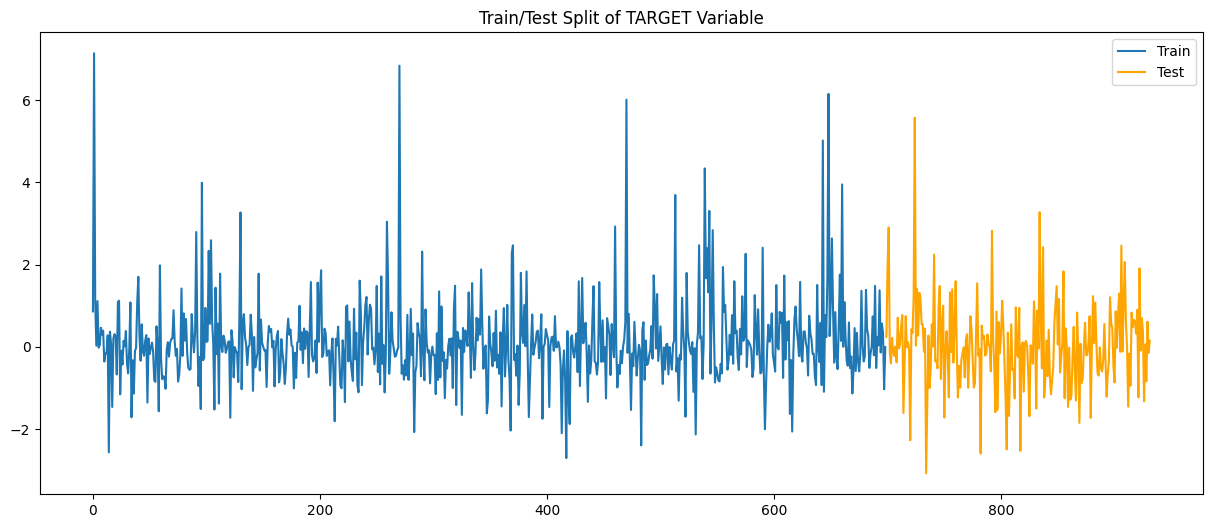

In [9]:
plt.figure(figsize=(15, 6))
plt.plot(train['TARGET'], label='Train')
plt.plot(test['TARGET'], label='Test', color='orange')
plt.title('Train/Test Split of TARGET Variable')
plt.legend()
plt.show()

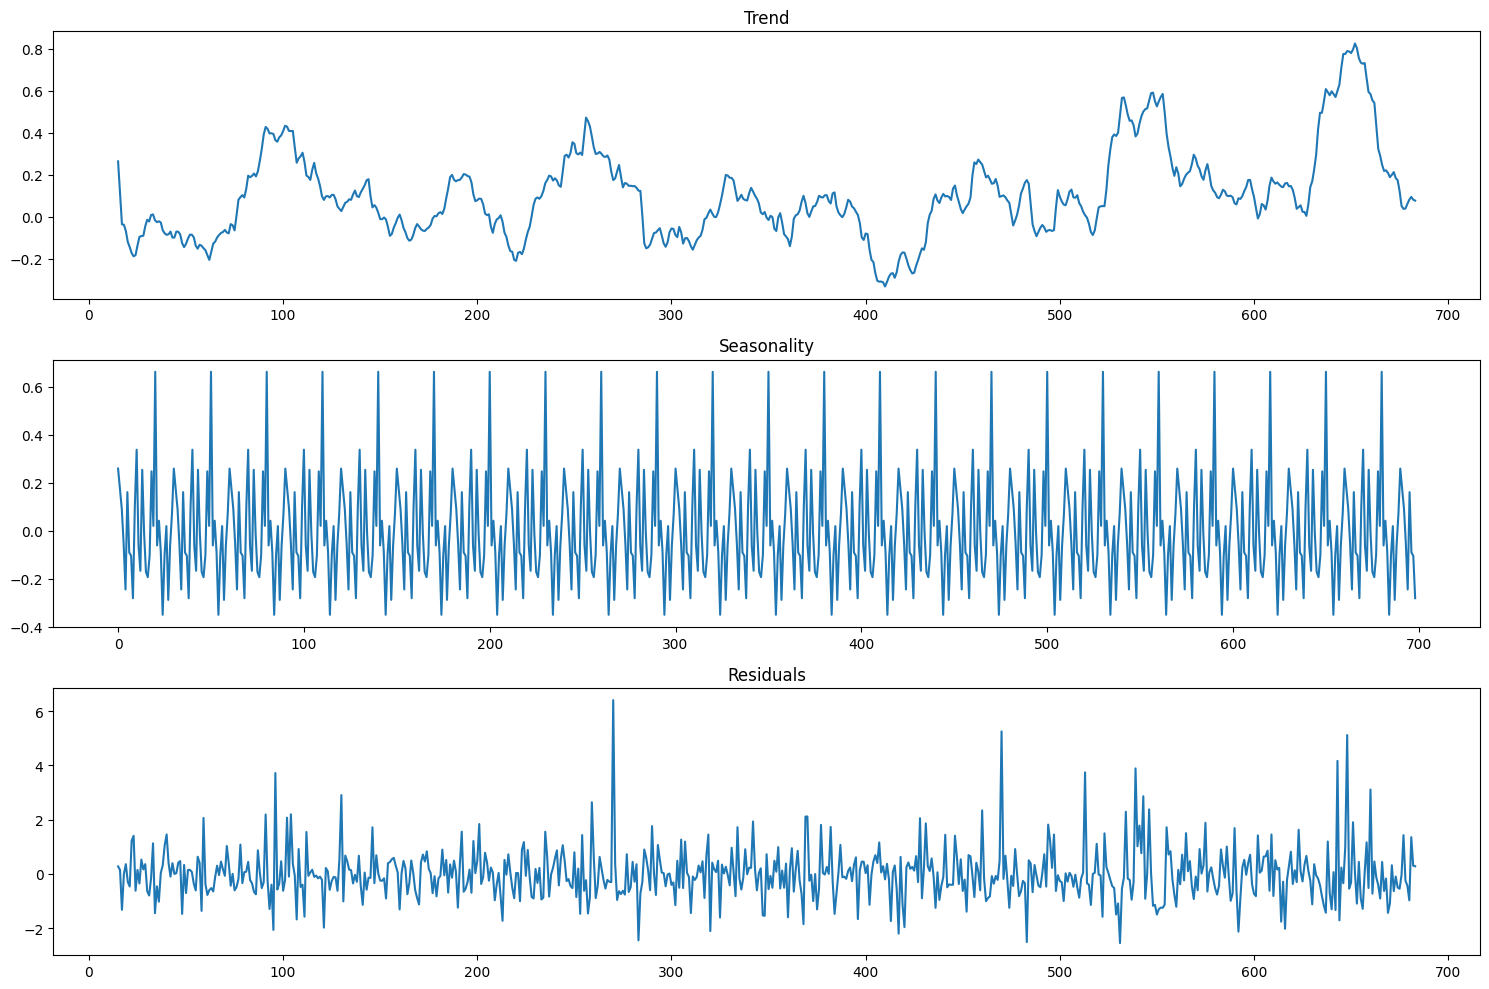

In [10]:
decomposed = seasonal_decompose(train['TARGET'], period=30)

plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<Figure size 1000x600 with 0 Axes>

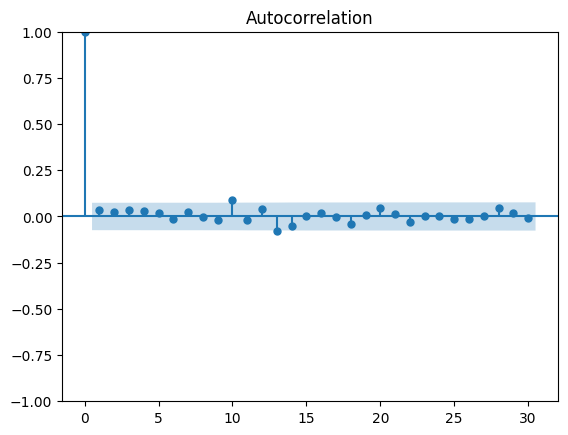

In [11]:
# Plotting the autocorrelation function (ACF)
plt.figure(figsize=(10, 6))
plot_acf(train['TARGET'], lags=30)
plt.show()

The graph starts with a coefficient of 1 at lag 0, which is natural since it represents the correlation of the time series with itself. Then, the coefficients for subsequent lags typically decrease. In this graph, it can be seen that after the initial decline, the autocorrelation coefficients remain around zero, which may indicate the absence of strong seasonality or trend.

In [12]:
from statsmodels.tsa.stattools import adfuller

# Check for stationarity
timeseries = train['TARGET']

# Applying the Dickey-Fuller test
result = adfuller(timeseries, autolag='AIC')

# Print the test results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Determine stationarity based on the statistical test and p-value
if result[1] > 0.05:
    print('The time series is non-stationary.')
else:
    print('The time series is stationary.')

ADF Statistic: -25.529276
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
The time series is stationary.


In [13]:
train.isna().sum()

DE_CONSUMPTION       0
DE_FR_EXCHANGE       0
DE_NET_EXPORT        0
DE_NET_IMPORT        0
DE_GAS               0
DE_COAL              0
DE_HYDRO             0
DE_NUCLEAR           0
DE_SOLAR             0
DE_WINDPOW           0
DE_LIGNITE           0
DE_RESIDUAL_LOAD     0
DE_RAIN             56
DE_WIND             56
DE_TEMP             56
TARGET               0
ID                   0
DAY_ID               0
dtype: int64

Since we have a time series, it would be best to use the `bfill` method to handle missing values. This method allows you to fill missing data in a time series using the next observed value in time. In the context of a time series, where the sequence of observations is important, the `bfill` method helps preserve the temporal structure of the data by suggesting that a future value can serve as a reasonable replacement for the missing value.

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


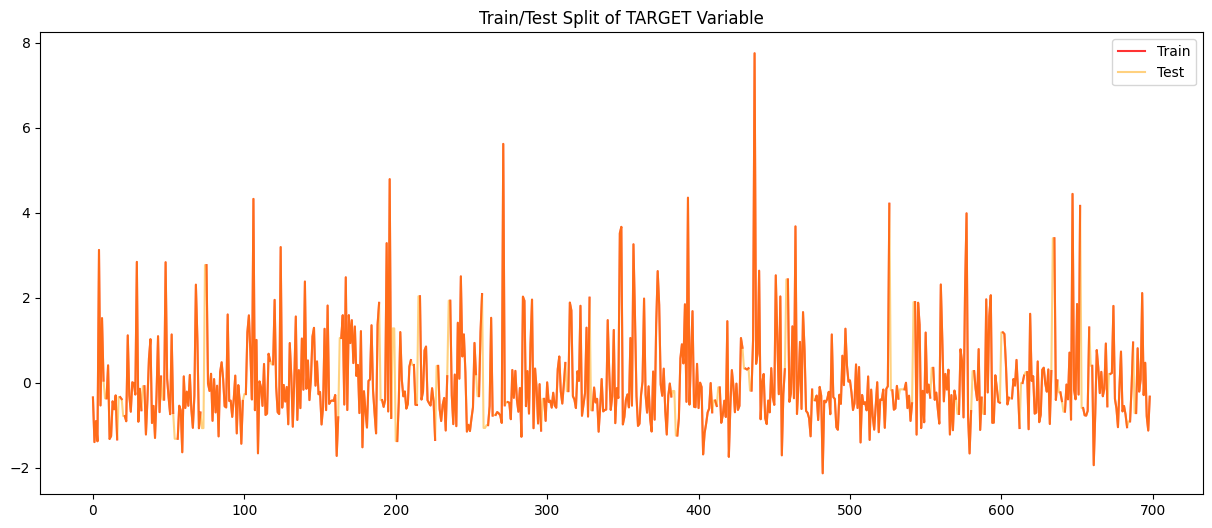

In [14]:
plt.figure(figsize=(15, 6))
plt.plot(train['DE_RAIN'], label='Train', color='red', alpha=0.8)
plt.plot(train['DE_RAIN'].fillna(method='bfill'), label='Test', color='orange', alpha=0.5)
plt.title('Train/Test Split of TARGET Variable')
plt.legend()
plt.show()

In [15]:
train.bfill(inplace=True)
train.head()

,DE_CONSUMPTION,DE_FR_EXCHANGE,DE_NET_EXPORT,DE_NET_IMPORT,DE_GAS,DE_COAL,DE_HYDRO,DE_NUCLEAR,DE_SOLAR,DE_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,DE_RAIN,DE_WIND,DE_TEMP,TARGET,ID,DAY_ID
0,-0.068972,-1.102015,-1.080403,1.080403,1.228079,-0.247704,1.785758,0.064726,-0.187892,-0.421844,-0.471366,0.398812,-0.344600,-0.623041,-0.148950,0.861270,111,2
1,-0.134670,-1.051716,-1.881881,1.881881,1.588542,-0.635452,1.994144,-2.002323,1.527633,-1.142488,-0.169336,0.275487,-1.394561,0.244859,-1.710888,7.138604,800,3
2,0.944117,0.372743,0.656335,-0.656335,0.451085,-0.752504,-0.291237,-0.624823,-0.576865,1.236785,0.234593,-0.204223,-0.900802,-0.614570,1.192221,1.103289,410,4
3,-0.297850,0.144615,-1.208286,1.208286,1.059828,-0.072071,1.275857,-1.875681,2.551925,-0.892244,-0.279690,-0.031595,-1.374757,0.333817,-0.062187,0.026374,831,5
4,0.120788,-1.195940,-1.670709,1.670709,1.524895,-0.079164,2.327561,-0.555858,0.609363,-1.216568,0.020925,0.982425,3.127472,0.324280,-0.288148,1.110984,562,6


In [16]:
train.isna().sum()

DE_CONSUMPTION      0
DE_FR_EXCHANGE      0
DE_NET_EXPORT       0
DE_NET_IMPORT       0
DE_GAS              0
DE_COAL             0
DE_HYDRO            0
DE_NUCLEAR          0
DE_SOLAR            0
DE_WINDPOW          0
DE_LIGNITE          0
DE_RESIDUAL_LOAD    0
DE_RAIN             0
DE_WIND             0
DE_TEMP             0
TARGET              0
ID                  0
DAY_ID              0
dtype: int64

Заполним пропуски

In [17]:
data_with_de.bfill(inplace=True)

Let's create a new feature: lags, moving statistics (average, standard deviation, minimum, maximum, sum) and exponential smoothing.

1. **Lags**: Including lag variables allows the model to account for dependencies in the data that extend back to previous time points. This helps the model better understand how previous values of the target variable can influence its future values.

2. **Rolling statistics**:
    - **Rolling Mean** helps smooth out time series, reducing the impact of short-term fluctuations and highlighting long-term trends.
    - **Rolling Std** indicates the variability or volatility of a time series over time.
    - **Rolling Min/Max** captures extreme values within a specific time window, which can be useful for identifying anomalies or sudden changes in data.
    - **Rolling Sum** can be useful for analyzing cumulative effects in data over a certain period.

3. **Exponential Smoothing**: This method gives more weight to more recent observations, which can be especially useful in cases where recent changes in the data are more informative for predicting future values.

In [18]:
def make_features(data, max_lag, rolling_mean_size, rolling_std_size):
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['TARGET'].shift(lag)

    data['rolling_mean'] = data['TARGET'].shift().rolling(rolling_mean_size).mean()
    data['rolling_std'] = data['TARGET'].shift().rolling(rolling_std_size).std()
    data['rolling_min'] = data['TARGET'].shift().rolling(rolling_mean_size).min()
    data['rolling_max'] = data['TARGET'].shift().rolling(rolling_mean_size).max()
    data['rolling_sum'] = data['TARGET'].shift().rolling(rolling_mean_size).sum()

    # exponential smoothing
    data['ewm'] = data['TARGET'].shift().ewm(span=rolling_mean_size).mean()
    return data

In [19]:
data_with_de = make_features(data_with_de, 30, 7, 7)

In [20]:
data_with_de = data_with_de.dropna()

In [21]:
feature = data_with_de.drop(['TARGET', 'ID'], axis=1)
target = data_with_de['TARGET']
X_train, X_test, y_train, y_test = train_test_split(feature, target, shuffle=False, test_size=0.25)

In [25]:
def plot_metrics_plot(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Metrics calculations
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    
    plt.figure(figsize=(15, 6))
    plt.plot(y_test.index, y_test, label='Actual', alpha=0.6)
    plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.6)
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Date')
    plt.ylabel('Target Variable')
    plt.legend()
    plt.show()

#### Lasso

In [22]:
# TimeSeriesSplit initialization
tscv = TimeSeriesSplit(n_splits=5)

# Creating a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('lasso', Lasso(random_state=12345))  # Lasso regression step
])

# Parameters for GridSearchCV
parameters = {
    'lasso__alpha': np.linspace(0.01, 1, 20)
}

# Creating and training the model with GridSearchCV

grid_search = GridSearchCV(pipeline,
                           parameters,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1,
                           cv=tscv)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Best parameters:', best_params)
print('Best rmse:', abs(best_score))

Best parameters: {'lasso__alpha': 0.11421052631578947}
Best rmse: 0.9934009670168024


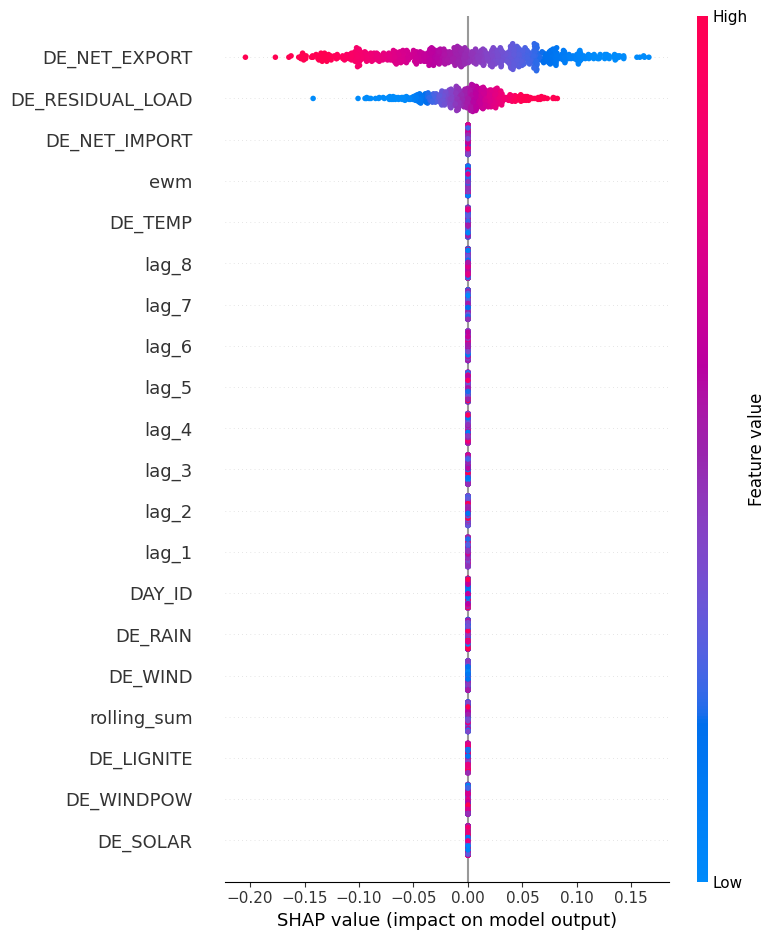

In [23]:
lasso_model = grid_search.best_estimator_.named_steps['lasso']
X_train_transformed = grid_search.best_estimator_.named_steps['scaler'].transform(X_train)

# Initializing SHAP Explainer
explainer = shap.Explainer(lasso_model, X_train_transformed)

# Computing SHAP values
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed, feature_names=X_train.columns, max_display=20)

I used L1 regularization to discard unnecessary features, as well as to avoid the influence of correlation on the result.

- **DE_NET_EXPORT (export)**: The smaller the export, the more the price changes in a positive direction over 24 hours.

- **DE_RESIDUAL_LOAD (residual load)**: The greater the residual load, the more the 24-hour price changes in a positive direction.

MSE: 1.0434077922758558
RMSE: 1.0214733438890393
MAE: 0.7406999569060211


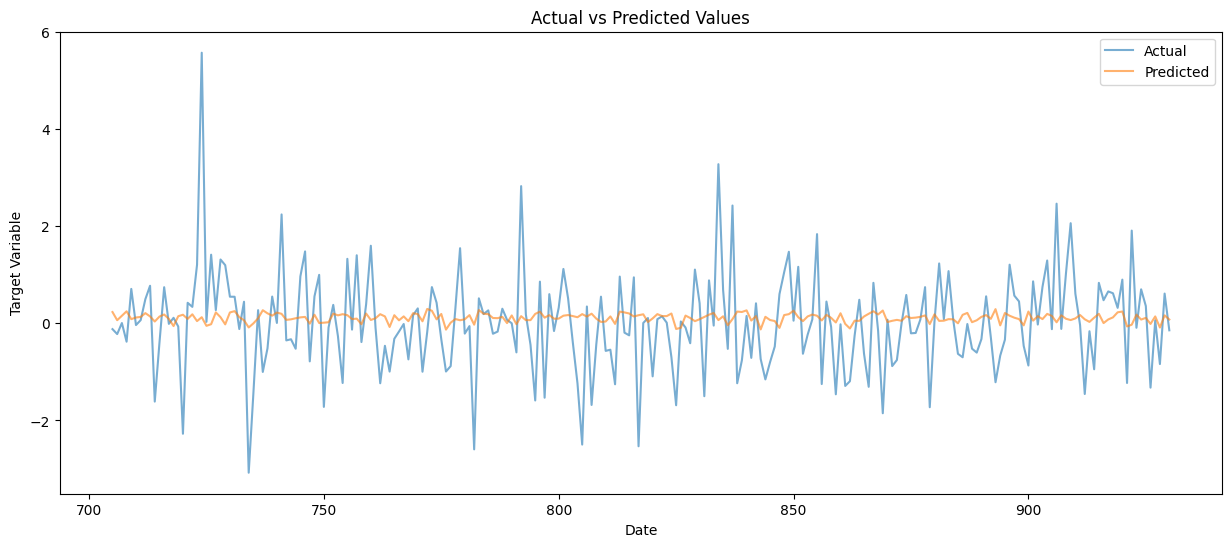

In [26]:
plot_metrics_plot(model=grid_search.best_estimator_,
                  X_test=X_test,
                  y_test=y_test)

#### Ridge

In [27]:
# Pipeline creation
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=12345))
])

parameters_ridge = {
    'ridge__alpha': np.linspace(0.1, 1, 10)
}

grid_search_ridge = GridSearchCV(pipeline_ridge,
                                 parameters_ridge,
                                 scoring='neg_root_mean_squared_error',
                                 n_jobs=-1,
                                 cv=tscv)
grid_search_ridge.fit(X_train, y_train)

best_params_ridge = grid_search_ridge.best_params_
best_score_ridge = grid_search_ridge.best_score_

print('Best parameters for Ridge:', best_params_ridge)
print('Best score for Ridge:', best_score_ridge)

Best parameters for Ridge: {'ridge__alpha': 1.0}
Best score for Ridge: -1.1115526973153


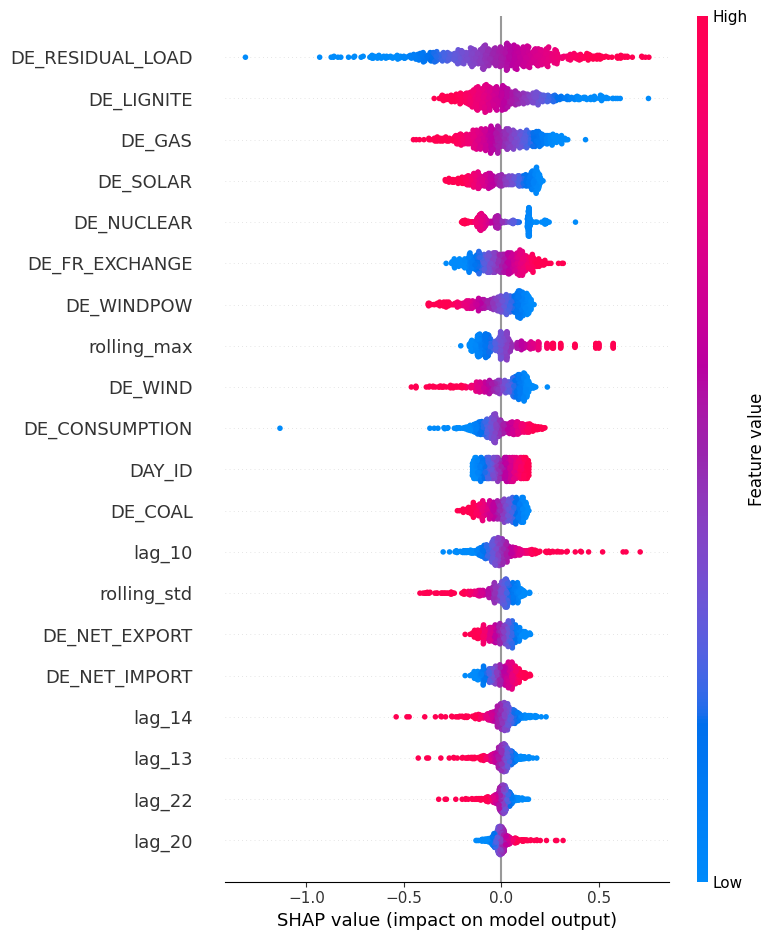

In [33]:
ridge_model = grid_search_ridge.best_estimator_.named_steps['ridge']
X_train_transformed = grid_search_ridge.best_estimator_.named_steps['scaler'].transform(X_train)

# Initializing SHAP Explainer
explainer = shap.Explainer(ridge_model, X_train_transformed)

# Computing SHAP values
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed, feature_names=X_train.columns, max_display=20)

- **DE_RESIDUAL_LOAD**: : The greater the residual load, the more the 24-hour price changes in a positive direction. (same output as for Lasso)

- **DE_LIGNITE, DE_GAS, DE_SOLAR**: These features are associated with different types of energy and show different effects on the model. They show that if they decrease, then the price changes more in a positive direction

MSE: 1.1869044290101771
RMSE: 1.089451434902069
MAE: 0.8090097353237962


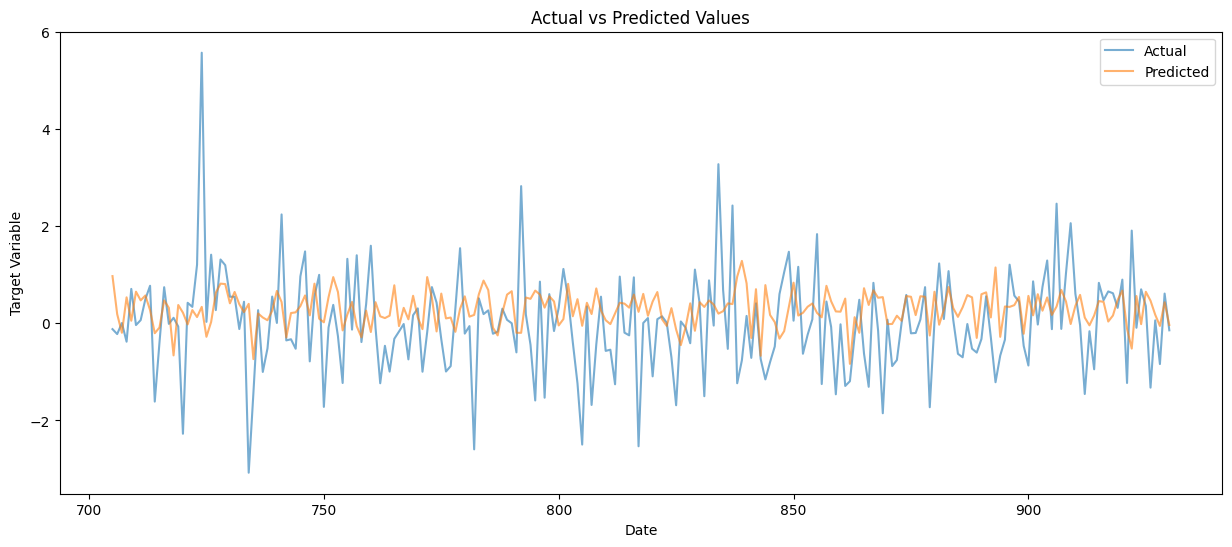

In [30]:
plot_metrics_plot(model=grid_search_ridge.best_estimator_,
                  X_test=X_test,
                  y_test=y_test)

#### RandomForestRegressor

In [31]:
parameters_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=12345),
                              parameters_rf,
                              scoring='neg_root_mean_squared_error',
                              n_jobs=-1,
                              cv=tscv)
grid_search_rf.fit(X_train, y_train)

print('Best parameters for Random Forest:', grid_search_rf.best_params_)
print('Best score for Random Forest:', grid_search_rf.best_score_)


Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best score for Random Forest: -1.0105532718630124


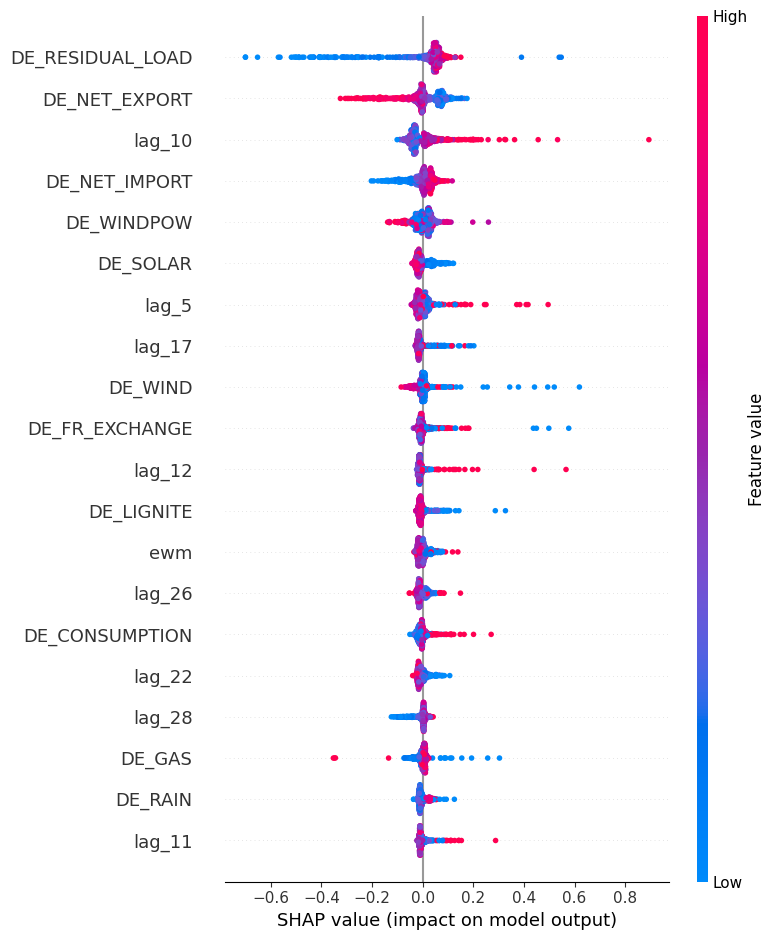

In [38]:
rf_model = grid_search_rf.best_estimator_
explainer = shap.Explainer(rf_model, X_train)

# Computing SHAP values
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, max_display=20)

- **DE_NET_EXPORT (export)**: The smaller the export, the more the price changes in a positive direction over 24 hours.

- **DE_RESIDUAL_LOAD (residual load)**: The greater the residual load, the more the 24-hour price changes in a positive direction.

Output as for Lasso

MSE: 1.1089180117397355
RMSE: 1.0530517611873291
MAE: 0.7939152446518668


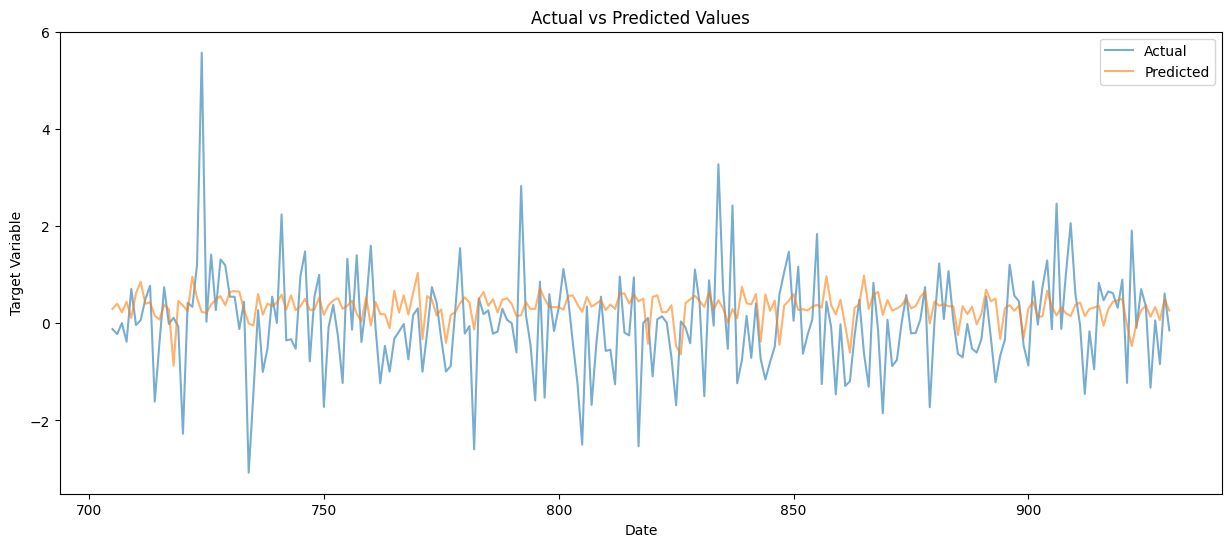

In [32]:
plot_metrics_plot(model=grid_search_rf.best_estimator_,
                  X_test=X_test,
                  y_test=y_test)

#### LGBMRegressor

In [40]:
lgbm = LGBMRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.01],
    'num_leaves':[31, 60],
    'max_depth': [3, 5, 7]
}

grid_search_light = GridSearchCV(estimator=lgbm,
                           param_grid=param_grid,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1,
                           cv=tscv)
grid_search_light.fit(X_train, y_train)

print("Best hyperparameters:", grid_search_light.best_params_)
print("Best cross-validation score:", grid_search_light.best_score_)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11483
[LightGBM] [Info] Number of data points in the train set: 675, number of used features: 52
[LightGBM] [Info] Start training from score 0.115987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

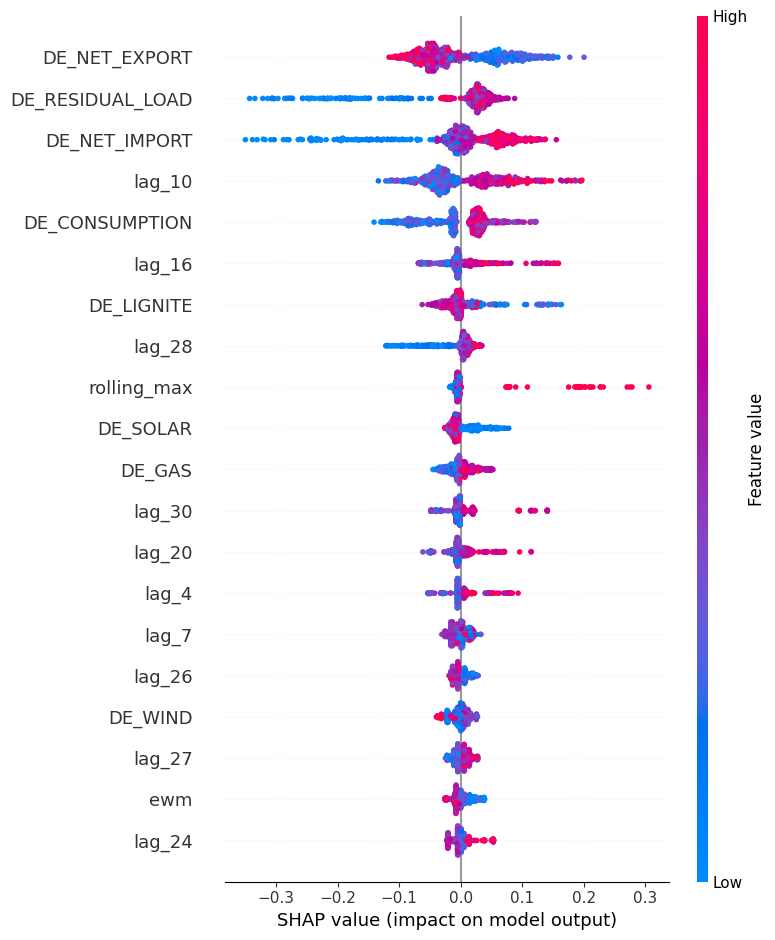

In [41]:
light_model = grid_search_light.best_estimator_
explainer = shap.Explainer(light_model, X_train)

# Computing SHAP values
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, max_display=20)


- **DE_NET_EXPORT (export)**: The smaller the export, the more the price changes in a positive direction over 24 hours.

- **DE_RESIDUAL_LOAD (residual load)**: The greater the residual load, the more the 24-hour price changes in a positive direction.

- **DE_NET_IMPORT (import)**: The greater the import, the more the price changes in a positive direction over 24 hours.

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
MSE: 1.038099680864828
RMSE: 1.0188717686072315
MAE: 0.7404990920165909


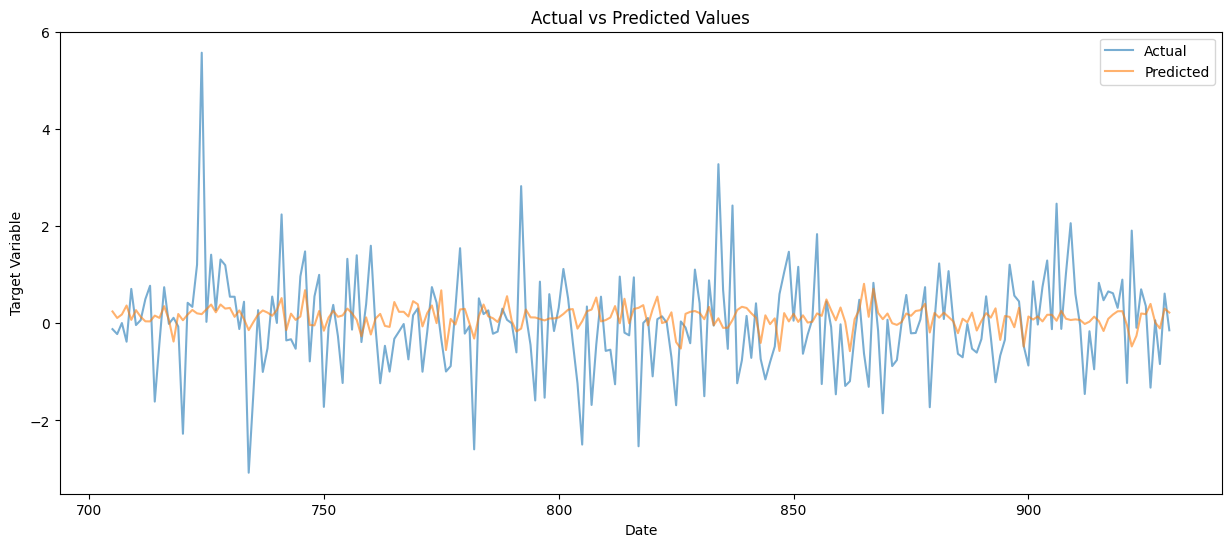

In [42]:
plot_metrics_plot(model=grid_search_light.best_estimator_,
                  X_test=X_test,
                  y_test=y_test)

**Conclusion**:

+ **DE_NET_EXPORT (export)**: If exports decrease, the price will only rise.

+ **DE_RESIDUAL_LOAD (residual load)**: The higher the residual load, the more the price will increase

+ **DE_NET_IMPORT (import)**: As imports increase, the price will rise.

##### Analyzing France data

In [43]:
columns_with_fr = [col for col in full_data.columns if col.startswith('FR_')] + ['TARGET', 'ID', 'DAY_ID', 'COUNTRY']
data_with_fr = full_data[columns_with_fr]
data_with_fr = data_with_fr.query('COUNTRY == "FR"').reset_index(drop=True)
data_with_fr.drop(columns=['COUNTRY'], inplace=True)

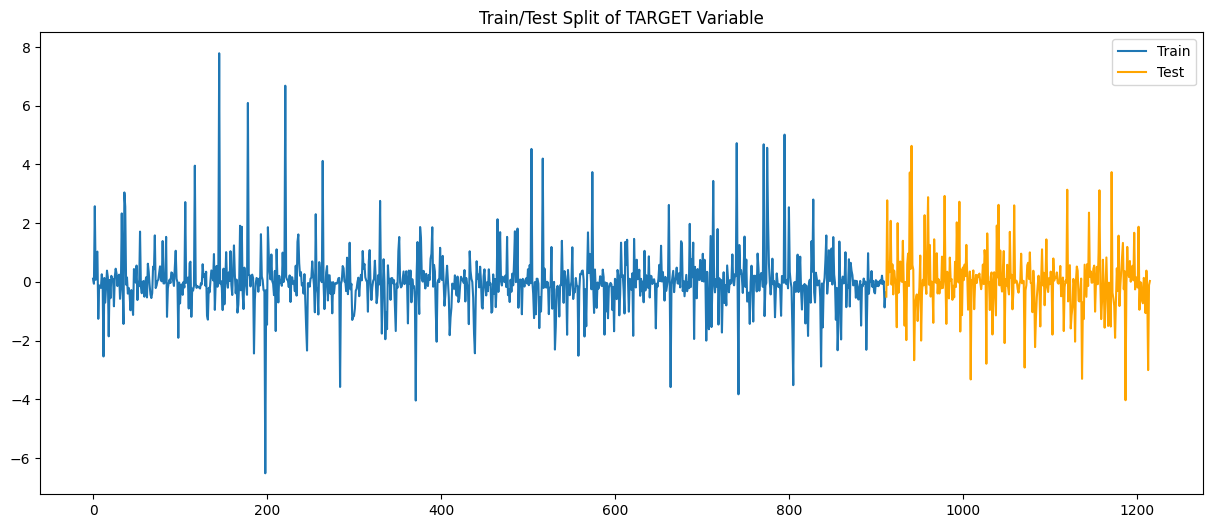

In [44]:
train, test = train_test_split(data_with_fr, test_size=0.25, shuffle=False)
plt.figure(figsize=(15, 6))
plt.plot(train['TARGET'], label='Train')
plt.plot(test['TARGET'], label='Test', color='orange')
plt.title('Train/Test Split of TARGET Variable')
plt.legend()
plt.show()

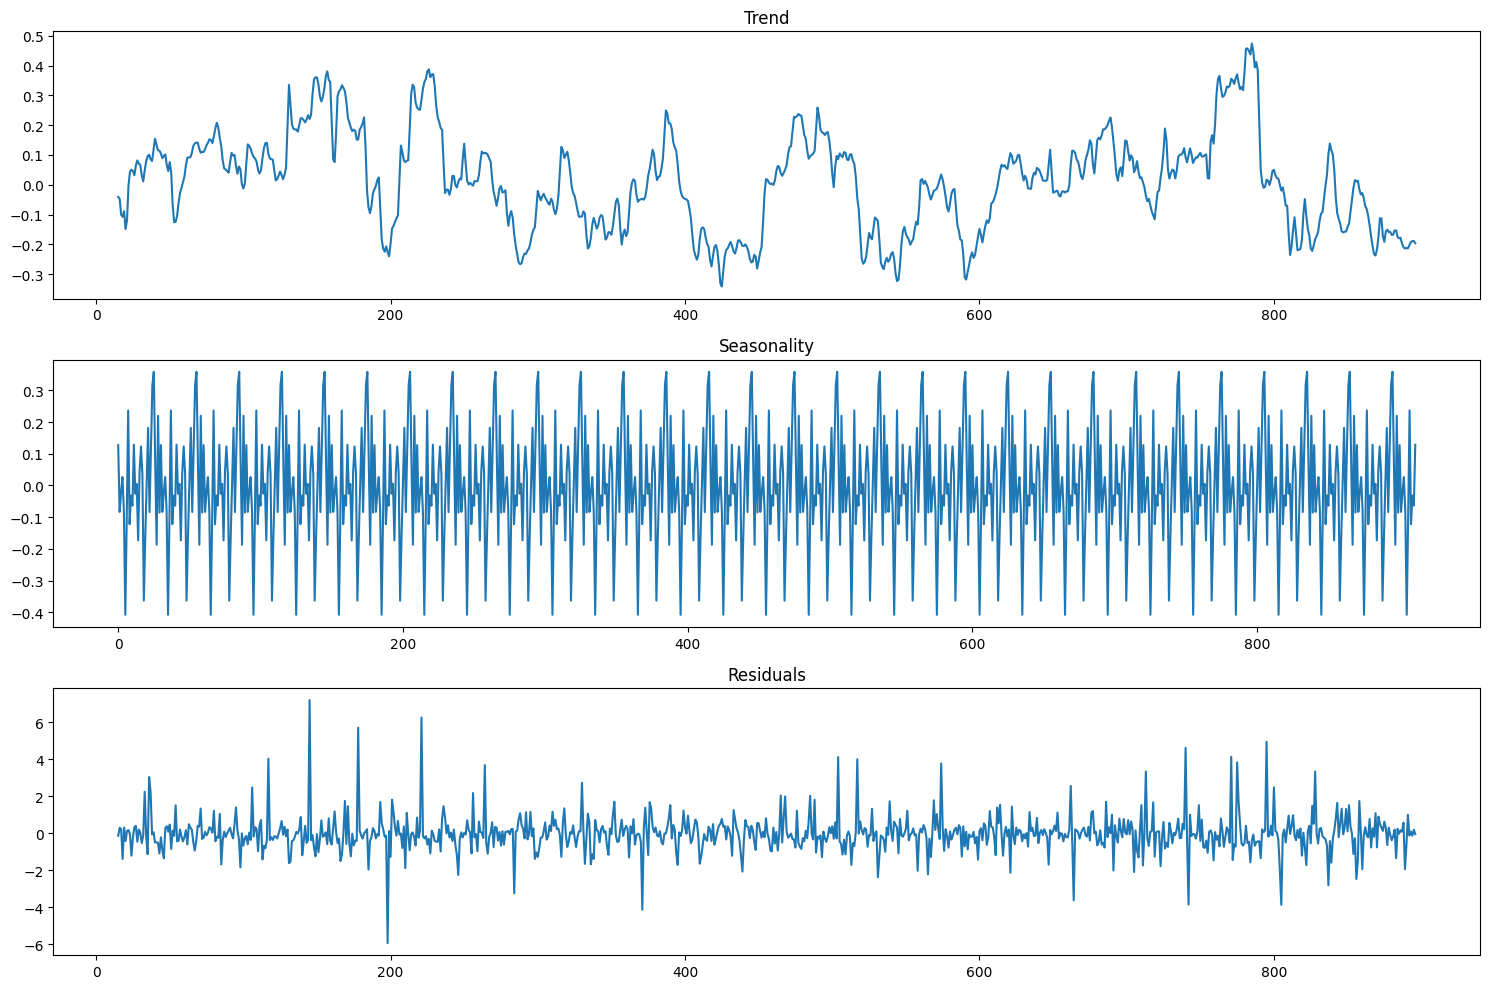

In [45]:
decomposed = seasonal_decompose(train['TARGET'], period=30)

plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<Figure size 1000x600 with 0 Axes>

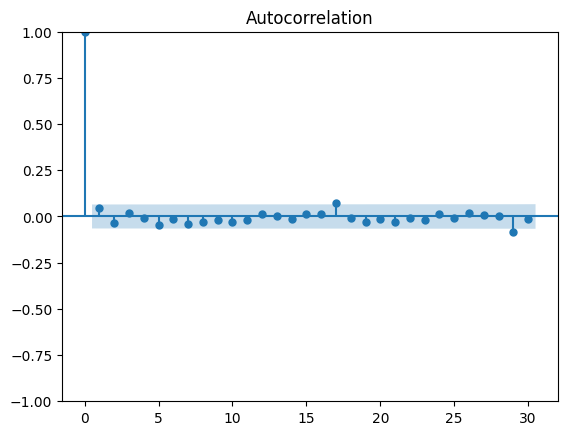

In [46]:
# Plotting the Autocorrelation Function (ACF)
plt.figure(figsize=(10, 6))
plot_acf(train['TARGET'], lags=30)
plt.show()

In [47]:
data_with_fr.bfill(inplace=True)
data_with_fr.head()

,FR_CONSUMPTION,FR_DE_EXCHANGE,FR_NET_EXPORT,FR_NET_IMPORT,FR_GAS,FR_COAL,FR_HYDRO,FR_NUCLEAR,FR_SOLAR,FR_WINDPOW,FR_RESIDUAL_LOAD,FR_RAIN,FR_WIND,FR_TEMP,TARGET,ID,DAY_ID
0,-0.465067,0.079296,0.650577,-0.650577,-0.261565,0.095197,0.677089,-0.357168,1.185155,-0.874690,-0.344706,-0.856204,-1.099226,0.583874,0.108953,1057,0
1,1.222131,-0.331356,0.778627,-0.778627,1.991028,-0.786509,0.709616,1.381575,0.485975,-0.172140,1.214288,-0.497520,-1.465608,0.231602,-0.063369,1179,1
2,-0.667390,1.102015,0.256736,-0.256736,0.458302,-0.766904,-0.930172,-0.379230,1.032412,-0.844350,-0.540642,-0.372156,-0.926064,0.641235,2.575976,1327,2
3,-0.834564,1.051716,-0.612133,0.612133,0.069297,-0.718729,-0.383690,-1.579208,2.986527,-0.718643,-0.856321,-1.118297,0.488650,-0.951057,0.068905,2016,3
4,0.203547,-0.372743,0.519380,-0.519380,0.865857,-0.782998,-0.170210,0.210166,0.028246,1.139577,-0.052684,-0.359430,-0.734964,0.701597,0.988223,1626,4


In [48]:
data_with_fr = make_features(data_with_fr, 30, 7, 7)
data_with_fr = data_with_fr.dropna()

In [49]:
feature = data_with_fr.drop(['TARGET', 'ID'], axis=1)
target = data_with_fr['TARGET']
X_train, X_test, y_train, y_test = train_test_split(feature, target, shuffle=False, test_size=0.25)

#### Lasso

In [50]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('lasso', Lasso(random_state=12345)) 
])


parameters = {
    'lasso__alpha': np.linspace(0.01, 1, 20)
}

grid_search_lasso = GridSearchCV(pipeline,
                           parameters,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1,
                           cv=tscv)
grid_search_lasso.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Best parameters:', best_params)
print('Best score:', best_score)

Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 31}
Best score: -0.9957061782044049


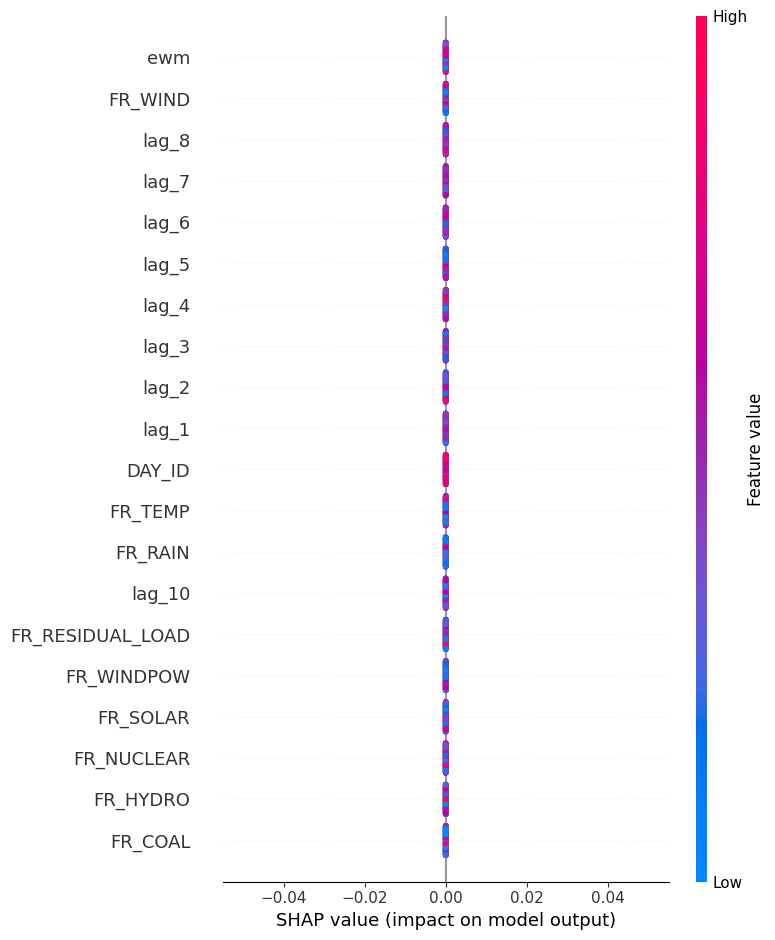

In [53]:
lasso_model = grid_search_lasso.best_estimator_.named_steps['lasso']
X_train_transformed = grid_search_lasso.best_estimator_.named_steps['scaler'].transform(X_train)

# Initializing SHAP Explainer
explainer = shap.Explainer(lasso_model, X_train_transformed)

# Computing SHAP values
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed, feature_names=X_train.columns, max_display=20)

MSE: 1.157119865319714
RMSE: 1.0756950614926677
MAE: 0.6873106633838607


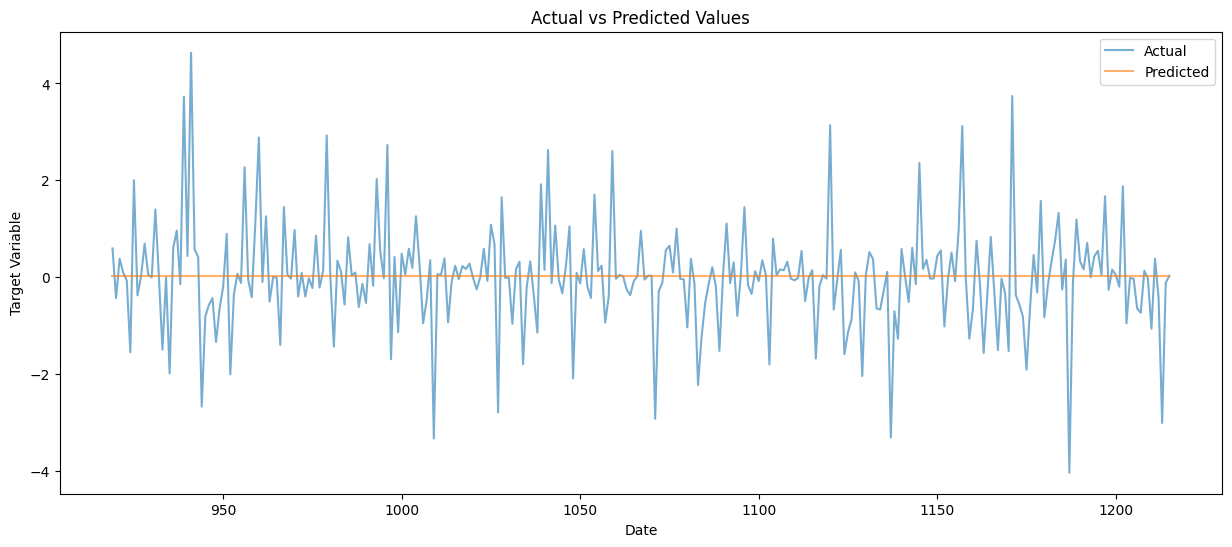

In [52]:
plot_metrics_plot(model=grid_search_lasso.best_estimator_,
                  X_test=X_test,
                  y_test=y_test)

##### The model zeroed out all the weight. The model considered that it is easiest to predict 0, so the metric will be the highest

#### Ridge

In [54]:
# Pipeline creation
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=12345))
])

parameters_ridge = {
    'ridge__alpha': np.linspace(0.1, 1, 10)
}

grid_search_ridge = GridSearchCV(pipeline_ridge,
                                 parameters_ridge,
                                 scoring='neg_root_mean_squared_error',
                                 n_jobs=-1,
                                 cv=tscv)
grid_search_ridge.fit(X_train, y_train)

best_params_ridge = grid_search_ridge.best_params_
best_score_ridge = grid_search_ridge.best_score_

print('Best parameters for Ridge:', best_params_ridge)
print('Best score for Ridge:', best_score_ridge)

Best parameters for Ridge: {'ridge__alpha': 1.0}
Best score for Ridge: -1.324258966593361


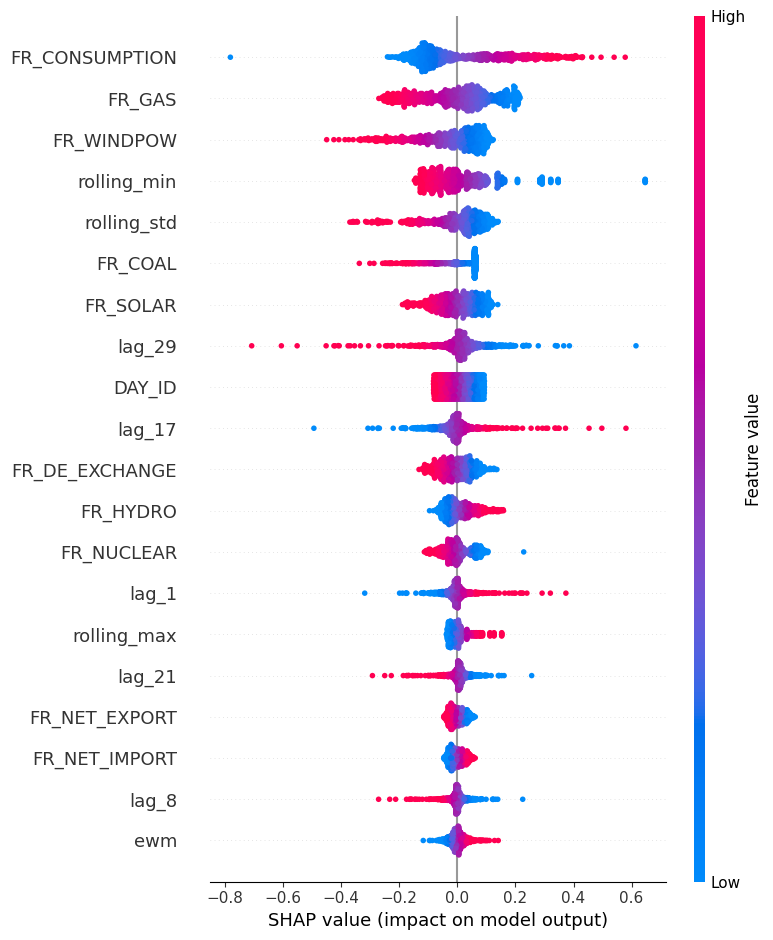

In [66]:
ridge_model = grid_search_ridge.best_estimator_.named_steps['ridge']
X_train_transformed = grid_search_ridge.best_estimator_.named_steps['scaler'].transform(X_train)

# Initializing SHAP Explainer
explainer = shap.Explainer(ridge_model, X_train_transformed)

# Computing SHAP values
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed, feature_names=X_train.columns, max_display=20)

1. **FR_CONSUMPTION**: This attribute reflects energy consumption in France. The larger it is, the more the price changes in a positive direction.

2. **FR_GAS**: Attribute related to the use of natural gas in France. The smaller it is, the more the price changes in a positive direction.

3. **FR_WINDPOW**: Feature associated with wind energy. It shows that a decrease in wind energy will also lead to an increase in price within 24 hours

MSE: 1.1931659811997435
RMSE: 1.0923213726736942
MAE: 0.728565645974607


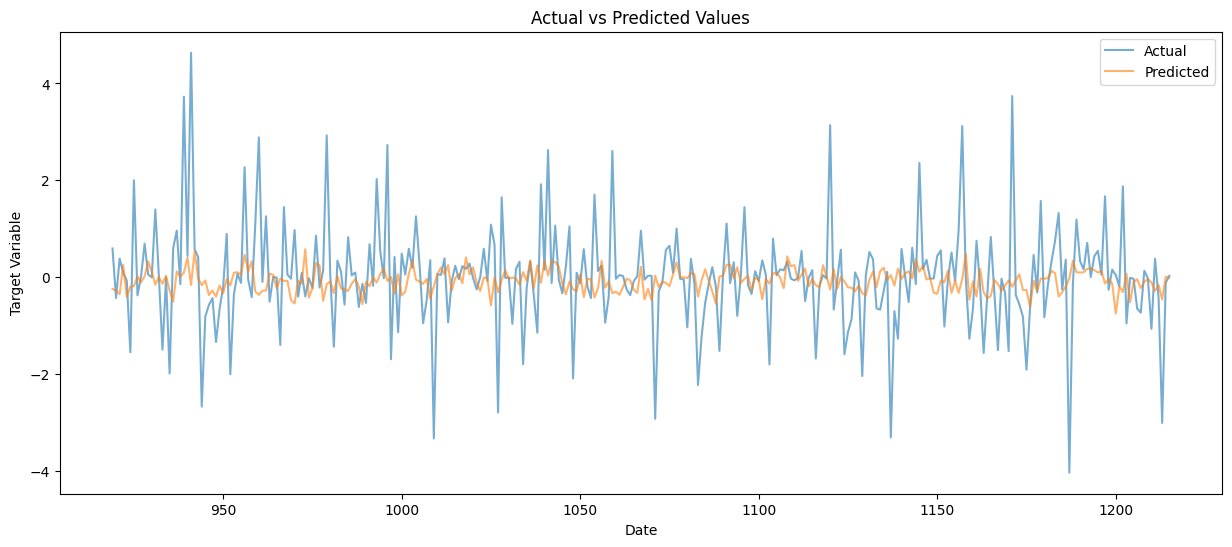

In [55]:
plot_metrics_plot(model=grid_search_ridge.best_estimator_,
                  X_test=X_test,
                  y_test=y_test)

#### RandomForestRegressor

In [58]:
parameters_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=12345),
                              parameters_rf,
                              scoring='neg_root_mean_squared_error',
                              n_jobs=-1,
                              cv=tscv)
grid_search_rf.fit(X_train, y_train)

print('Best parameters for Random Forest:', grid_search_rf.best_params_)
print('Best score for Random Forest:', grid_search_rf.best_score_)


Best parameters for Random Forest: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best score for Random Forest: -1.1226650282500972


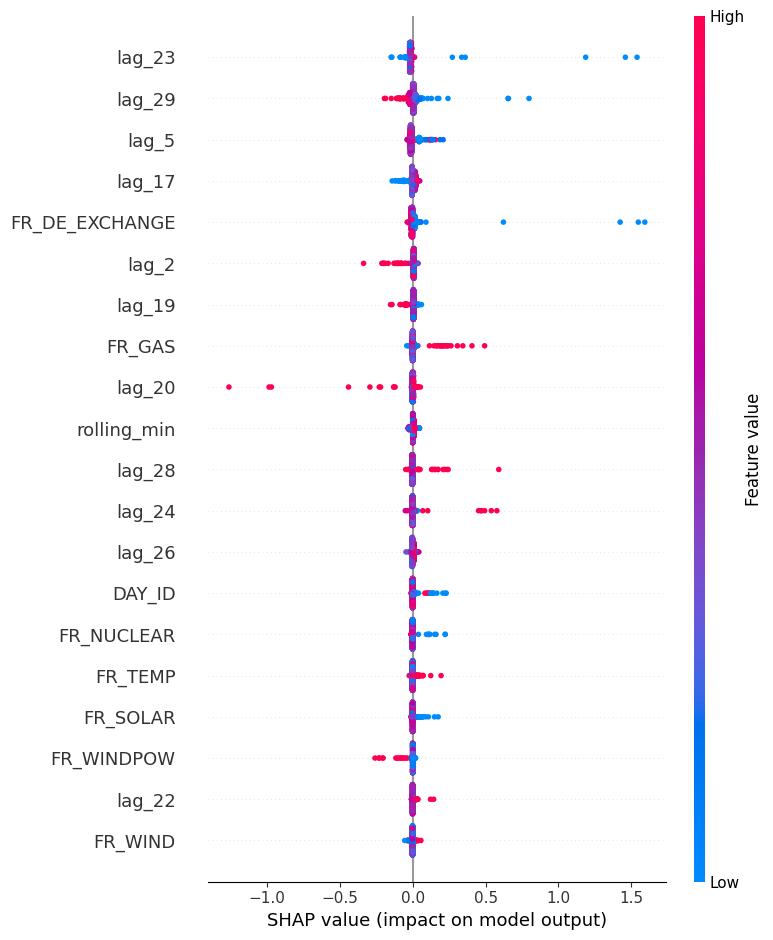

In [60]:
rf_model = grid_search_rf.best_estimator_
explainer = shap.Explainer(rf_model, X_train)

# Computing SHAP values
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, max_display=20)

MSE: 1.1975908552601284
RMSE: 1.0943449434525334
MAE: 0.7157463170622606


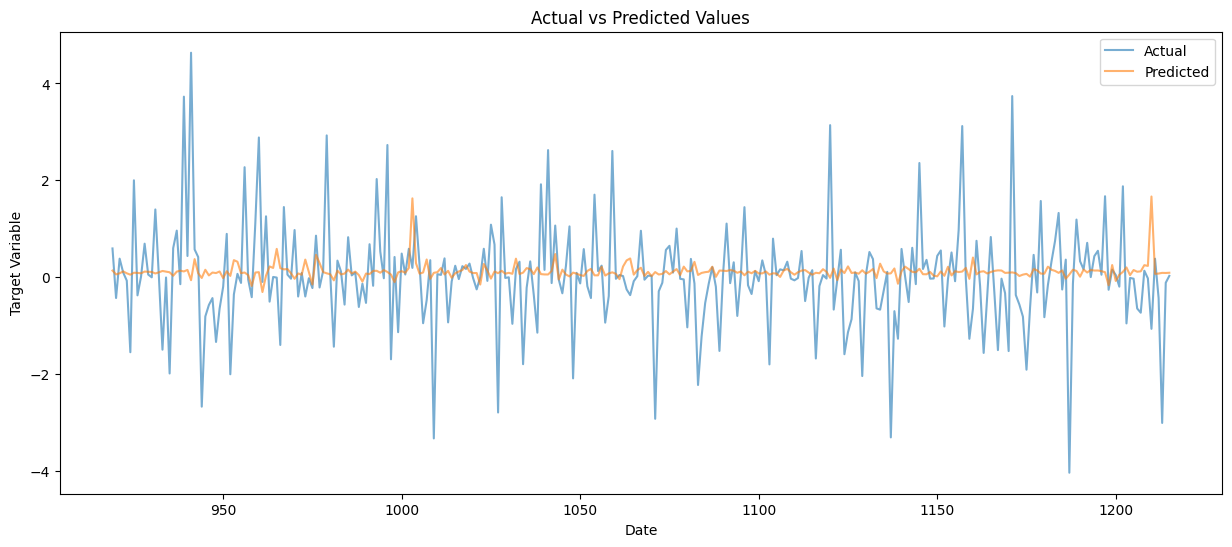

In [62]:
plot_metrics_plot(model=grid_search_rf.best_estimator_,
                  X_test=X_test,
                  y_test=y_test)

#### LGBMRegressor

In [63]:
lgbm = LGBMRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7]
}

grid_search_light = GridSearchCV(estimator=lgbm,
                           param_grid=param_grid,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1,
                           cv=tscv)
grid_search_light.fit(X_train, y_train)

print("Best hyperparameters:", grid_search_light.best_params_)
print("Best cross-validation score:", grid_search_light.best_score_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12823
[LightGBM] [Info] Number of data points in the train set: 889, number of used features: 51
[LightGBM] [Info] Start training from score 0.017280
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

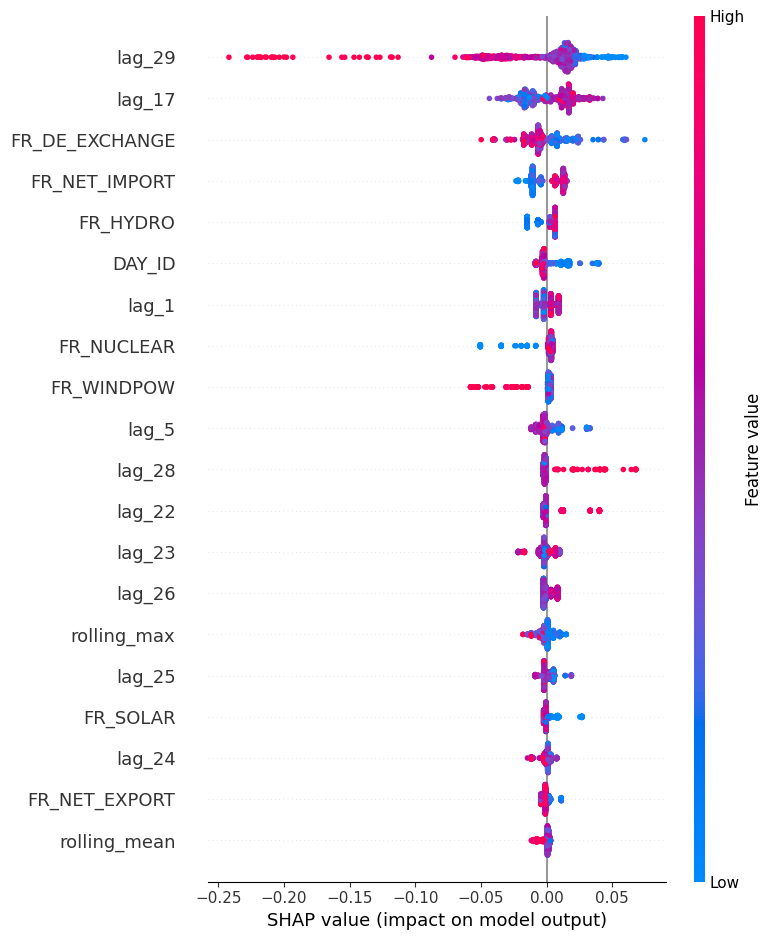

In [64]:
light_model = grid_search_light.best_estimator_
explainer = shap.Explainer(light_model, X_train)

# Computing SHAP values
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, max_display=20)

LightGBM считает, что 

1. **FR_DE_EXCHANGE**: Уменьшение данной фичи приведет к повышению цены 

2. **FR_NET_IMPORT**: При повышении импорта, цена будет падать 

3. **FR_WINDPOW**: Признак, связан с ветровой энергией. Он показывает, что уменьшение ветровой энергии, так же приведет к росту цены в течении 24 часов

MSE: 1.1665513622724728
RMSE: 1.0800700728529018
MAE: 0.6963167878933099


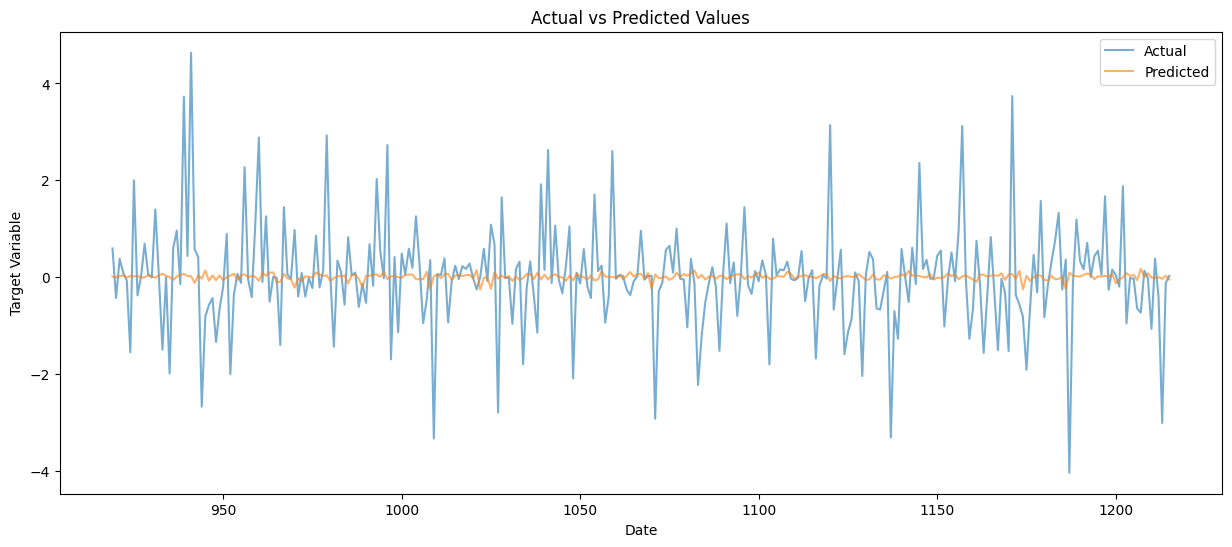

In [65]:
plot_metrics_plot(model=grid_search_light.best_estimator_,
                  X_test=X_test,
                  y_test=y_test)

**Conclusion**:

1. **FR_DE_EXCHANGE**: Reducing this feature will lead to an increase in price

2. **FR_NET_IMPORT**: When imports increase, the price will fall

3. **FR_WINDPOW**: Feature associated with wind energy. It shows that a decrease in wind energy will also lead to an increase in price within 24 hours
4. **FR_CONSUMPTION**: This attribute reflects energy consumption in France. The larger it is, the more the price changes in a positive direction.

5. **FR_GAS**: Attribute related to the use of natural gas in France. The smaller it is, the more the price changes in a positive direction.